### Demo prep

In [30]:
session.sql('create or replace table retail.transactions.enriched_data as select * from demo_prep.transactions.new_transactions1m_4').collect()
# session.sql('create or replace table retail.transactions.new_transactions as select * from new_transactions1m_4').collect()

[Row(status='Table ENRICHED_DATA successfully created.')]

In [23]:
session.sql('alter session set qa_mode=true').collect()
session.sql('alter session set enable_python_udf=true').collect()
session.sql('alter session set USE_ANACONDA_PYTHON_RUNTIME_IN_REMOTE_DEPLOYMENT = true').collect()
session.sql('alter session set ENABLE_PYTHON_UDF_INFO_SCHEMA_SHOW_AVAILABLE_PACKAGES = true').collect()
session.sql('alter session set PYTHON_UDF_PRPR_EXPOSE_PACKAGES = true').collect()
session.sql('alter session set ENABLE_DOP_DOWNGRADE = false').collect()
session.sql('alter session set ENABLE_PTRACE_SUPERVISOR_REPORT = false').collect()

[Row(status='Statement executed successfully.')]

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
onehotEncoder = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown = 'ignore'), [0, 1, 2, 3, 4])], 
                                  remainder='passthrough')
onehotEncoder = ColumnTransformer([('ordinal', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1), [0, 1, 2, 3, 4])], 
                                  remainder='passthrough')

In [25]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier
from matplotlib_venn import venn2
from demo_prep import bokeh_plot_distance_feature
from pandas import DataFrame
from config import snowflake_connection_params
import matplotlib.pyplot as plt
import numpy as np

## StyleMeUp - Fraud Detection in Online Retail 
### Data Scientist Notebook

In [26]:
from snowflake.snowpark.session import Session
from config import snowflake_connection_params

session = Session.builder.configs(snowflake_connection_params).create()

In [31]:
train_dataset = session.table('enriched_data').sample(n = 10000)
df = train_dataset.toPandas()

## Data Exploration
### Masked IP feature visualization

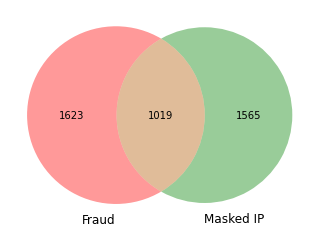

In [32]:
venn2(subsets = (len(df.loc[df['ISFRAUD'] == 1]), 
                 len(df.loc[df['IS_MASKED'] == 1]), 
                 len(df.loc[(df['ISFRAUD'] == 1) & (df['IS_MASKED'] == 1)])),
      set_labels = ('Fraud', 'Masked IP', 'Fraud & Masked IP'))
plt.show()

### Distance feature visualization

In [33]:
bokeh_plot_distance_feature(df)

Loading BokehJS ...

## Training fraud detection model

### Preparing training data

In [34]:
features = ['CITY', 'SHIPPING_ZIPCODE', 'SHIPPING_STATE', 'PAYMENT_NETWORK', 'PAYMENT_TYPE', 
            'IS_MASKED', 'AVG_TRNX_AMOUNT_PER_ITEM', 'TOTAL_TRNX_AMOUNT', 'IP_TO_SHIPPING_DISTANCE']
X = df[features]
y = df['ISFRAUD'] == True
weights = (y==0).sum()/(1.0 *  (y==1).sum())

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Training the model

In [35]:
model = make_pipeline(
            onehotEncoder,
            XGBClassifier(objective="binary:logistic", eval_metric="auc", scale_pos_weight = weights, use_label_encoder=False, nthread=1))

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model training complete.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model training complete.
   - Model Balanced Accuracy: 90.28%


### Feature importance

Text(0.5, 0, 'Feature Importance')

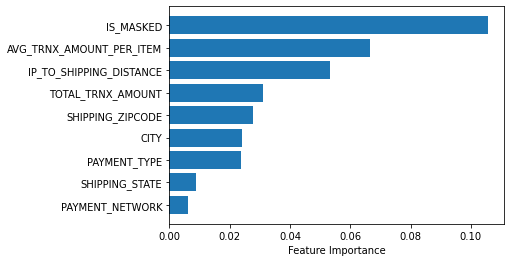

In [36]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

## Scikit-Learn Model Inference in Snowflake
### Registering Python function in Snowflake

In [37]:
session.addPackages(['scikit-learn', 'xgboost'])

@udf(is_permanent = True, stage_location = 'stage')
def detect_fraud(city: str, zipcode: str, state: str, network: str, payment_type: str, 
                  is_masked: bool, avg_amount: float, total_amount: float, ip_distance: float) -> bool:
    row = DataFrame([[city, zipcode, state, network, payment_type, is_masked, avg_amount, total_amount, ip_distance]], columns=features)
    return model.predict(row)[0]


### Running model inference in Snowflake

In [38]:
new_df = session.table(name = 'new_transactions')

In [39]:
%%time
new_df.select(new_df.trnx_id,
              detect_fraud(new_df.city, new_df.shipping_zipcode, new_df.shipping_state,
                                new_df.payment_network, new_df.payment_type, new_df.is_masked, 
                                new_df.avg_trnx_amount_per_item, new_df.total_trnx_amount,
                                new_df.ip_to_shipping_distance).alias('fraud_flag')) \
      .write.mode('overwrite').saveAsTable('fraud_detection')

CPU times: user 9.68 ms, sys: 2.77 ms, total: 12.4 ms
Wall time: 10.3 s


In [40]:
session.table('fraud_detection').limit(10).toPandas()

,TRNX_ID,FRAUD_FLAG
0,XRXWIQ45G2938449,False
1,65Z4YQ541I167617,False
2,67H6W91HHB169191,True
3,69TJGH6H6W171234,False
4,69TJGH6H6W171250,False
5,6EDY96XCKS174867,False
6,6UVZQPJWJP186480,True
7,6E915VLF4K174721,False
8,MCHZJ2XDUJ614398,False
9,MDLYWREMJV615789,True
